# ADA final exam (Fall 2021)

This exam consists of 2 parts.
The first part has 3 tasks.
The second part has 2 tasks.
The two parts are completely independent of each other.

## Important: The data used for this exam **is not entirely real.** A great deal of it has been artificially created or modified. Conclusions drawn from this data have no real link to reality!

In [3]:
''' Package import test '''
import os
import gzip
import random
import pickle
import re
import itertools
import collections
import operator
import requests
from urllib.parse import *
from datetime import *
from dateutil.parser import parse

import math
import sklearn
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import *

import ast
import gensim
import string
import nltk
import codecs
import json
import vaderSentiment
import spacy
from empath import Empath
from bs4 import BeautifulSoup

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

print("Package import test successful!")


# General
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For graph-related stuff
import networkx as nx

# For regression analyses and statistical tests
import scipy.stats as stats
import statsmodels.stats
import statsmodels.formula.api as smf

# For classification
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Package import test successful!



## Part 1 — Faculty hiring network

For the first part of the exam, you will analyze data from a faculty hiring network. After completing their Ph.D., researchers who want to pursue an academic career must compete for relatively few permanent positions (as “faculty”, i.e., professors) in a highly competitive job market. You will analyze a directed graph that captures the dynamics of this hiring process in the United States:


- Each node $u$ in this graph represents a different American university.
- For each university, we also provide a score that captures how highly  this university is ranked (e.g., Stanford University is ranked more highly than the University of Alabama). The higher the score, the more highly ranked the university.
- Each directed edge $(u,v)$ in this graph represents a hiring decision where someone who did their Ph.D. at university $u$ subsequently was hired by university $v$. Each edge is also associated with a gender label, which specifies if the person hired was a man (M) or a woman (F).
- Note that, when multiple researchers were trained at a given university $u$ and subsequently hired by university $v$, there will be multiple edges pointing from $u$ to $v$, each of which corresponds to a different person.


## Files (in the `./data/part-1/` folder)

- `nodelist.tsv` a tab-separated file containing the nodes of the graph. Recall that each node represents a different university. The file has these columns:
    - `u` — the node index;
    - `score` — the rank of the university (the higher the better);
    - `name` — the name of the university.

- `edgelist.tsv` a tab-separated file containing the edges of the graph. Recall that each edge represents a hiring decision. The file has columns:
    - `u` — the source university, where the person got their Ph.D.;
    - `v` — the target university, where the person was hired;
    - `gender` — the gender of the person.


### Task 1 — (20 points)

1. Using the above files, create the directed graph representing the hiring network using `networkx`.
Each node should contain the attributes `score` and `name`, and each edge should contain the attribute `gender`.
Print the total numbers of nodes and edges in the graph.

2. Create a plot that allows you to easily visualize **(a)** what fraction of all researchers in the graph are hired by the $N$ universities that hire the most; and  **(b)** what fraction of all researchers in the graph are trained by the $N$ universities whose students get hired the most.
Here, $N$ could be any number between 1 and the number of universities.

3. **/Multiple choice:/** Which centrality metric(s) is/are illustrated in the plot you made for the previous subtask? Select all that apply from the list below and **justify your answer.**
    1. Betweenness centrality
    2. In-degree centrality
    3. Out-degree centrality
    4. PageRank centrality

4. **/True or false:/** Search engines such as Google have historically used PageRank centrality as a signal to determine the importance of pages on the Web. Is the following statement **true** or **false**? Justify. **"In the faculty hiring network, PageRank centrality is positively correlated with university score, that is, universities with higher scores are more likely to also have higher PageRank centrality."**


In [9]:
# 1.
nodelist = pd.read_csv("data/part-1/nodelist.tsv", sep="\t")

assert nodelist.isna().sum().sum() == 0

nodelist.head()

,u,score,name
0,1,100.000000,Stanford University
1,2,99.956665,UC Berkeley
2,3,99.301230,MIT
3,4,98.369536,California Institute of Technology
4,5,97.892855,Harvard University


In [10]:
edgelist = pd.read_csv("data/part-1/edgelist.tsv", sep="\t")

assert edgelist.isna().sum().sum() == 0

edgelist.head()

,u,v,gender
0,1,1,F
1,1,1,F
2,1,1,F
3,1,1,M
4,1,1,M


In [21]:
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]), font_size=7)
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_shape=node_shape)
    plt.axis('off')

In [48]:
g_task1 = nx.MultiDiGraph()
g_task1.add_nodes_from(nodelist.u)
nx.set_node_attributes(g_task1, nodelist.name, "name")
nx.set_node_attributes(g_task1, nodelist.score, "score")
print(g_task1.nodes[4]["name"], " (should be Harvard u.)")

# edges = {}
edges = []
for _, e in edgelist.iterrows():
    # key = (e.u, e.v)
    # edges[key] = edges.get(key, 0)[0] (1, e.gender)
    # print(e)
    edges.append((e.u, e.v, {"gender": e.gender}))

g_task1.add_edges_from(edges)
visualize_graph(g_task1)

In [49]:
print(f"Number of nodes: {len(g_task1.nodes())}")
print(f"Number of edges: {len(g_task1.edges())}")

Number of nodes: 205
Number of edges: 4388


In [50]:
assert len(nodelist) == len(g_task1.nodes())
assert len(edgelist) == len(g_task1.edges())

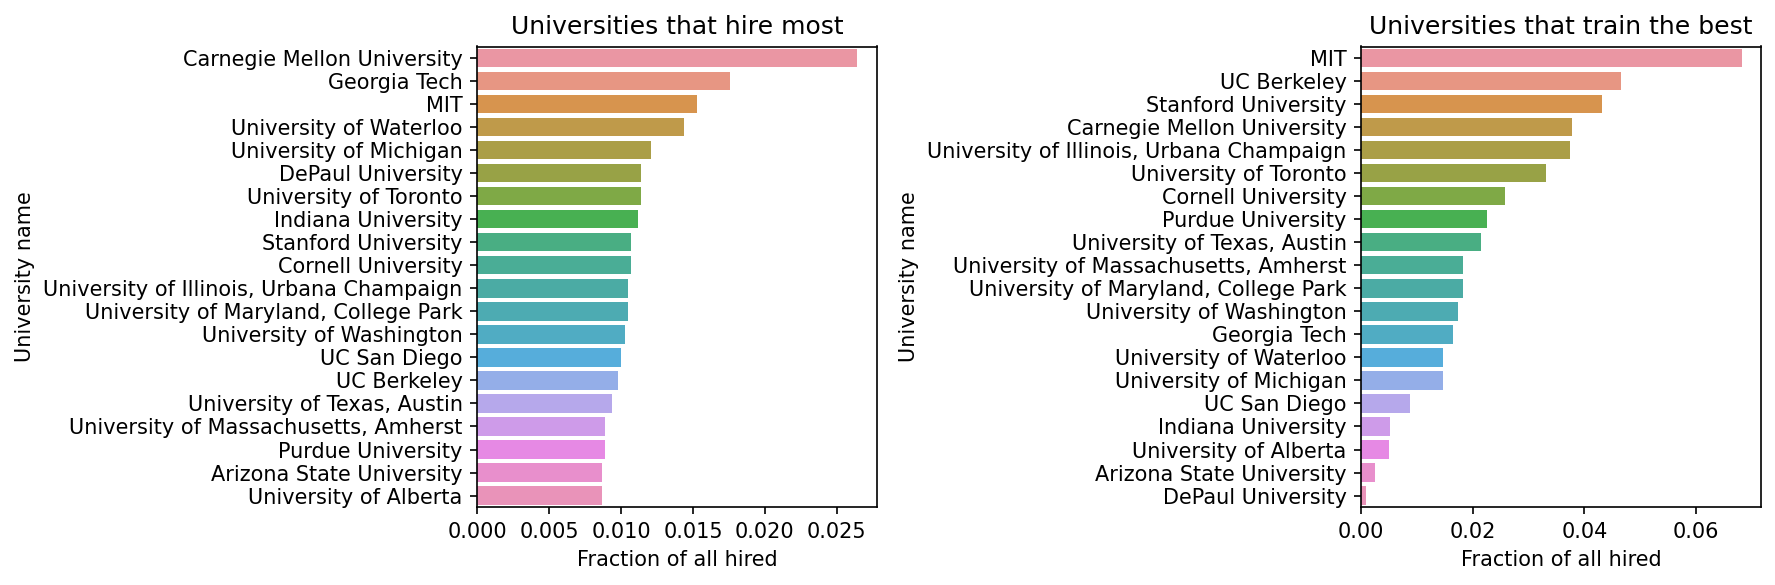

In [94]:
# 2.

N = 20
E = len(edgelist)

top_hiring = nodelist.merge(edgelist, left_on="u", right_on="v").groupby(["u_x", "name"])["v"].count().sort_values(ascending=False)[:N]
top_hiring_list_u = [u for u, name in top_hiring.index]
top_hiring_list_name = [name for u, name in top_hiring.index]

top_trained = nodelist.merge(edgelist, left_on="u", right_on="u")
top_trained = top_trained[top_trained.u.isin(top_hiring_list_u)].groupby(["u", "name"])["v"].count().sort_values(ascending=False)
top_trained_list_u = [u for u, name in top_trained.index]
top_trained_list_name = [name for u, name in top_trained.index]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), dpi=150)

sns.barplot(x=top_hiring/E, y=top_hiring_list_name, ax=ax1)
ax1.set_title("Universities that hire most")
ax1.set_xlabel("Fraction of all hired")
ax1.set_ylabel("University name")

sns.barplot(x=top_trained/E, y=top_trained_list_name, ax=ax2)
ax2.set_title("Universities that train the best")
ax2.set_xlabel("Fraction of all hired")
ax2.set_ylabel("University name")

plt.tight_layout()
plt.show()



**Comment for 3:**

The following:
- In-degree centrality (hiring)
- Out-degree centrality (training)


These two because this is exactly what we measured - the number of neighbours in the graph created. The PageRank is false because even if we compute the indegree, we do not do so in a stohastic manner that pagerank requires, where each node has some kind of reputation that also accounts for the score it will contribute with when given in the in-degree. Betweeness not because we compute no shortest paths and there is no notion of them.

Note that we compute the out-degree for only the top universities, so some might be missed in the ranking!

---

In [97]:
nodelist.sort_values("score", ascending=False).head(10)

,u,score,name
0,1,100.000000,Stanford University
1,2,99.956665,UC Berkeley
2,3,99.301230,MIT
3,4,98.369536,California Institute of Technology
4,5,97.892855,Harvard University
5,6,96.717404,Cornell University
6,7,96.181139,Carnegie Mellon University
7,8,96.159471,Princeton University
8,9,95.801961,Yale University
9,10,95.216944,University of Washington


**Comment for 4:**

To give a justification (so no code and proof), I claim that the statement is true with the justification that better universities should have higher scores (if the score metric is computed in a meaningful way) and the better a university is, the higher it's in-degree will

In fact, there is some correspondance between the list of highest-score universities and the hiring list we have, note that the hiring list is the in-degree and could give a vague notion of how pagerank would look like.

---

### Task 2 — (15 points)

Each hiring decision $(u,v)$ connects two different universities with different scores.

1. Divide the universities into quintiles according to their scores ($Q_1$ to $Q_5$, where $Q_5$ contains the highest-ranked universities, i.e., those with the highest scores). Create a succinct plot that captures, for each pair of quintiles ($Q_i$, $Q_j$), what fraction of people in the dataset who got their Ph.D. from a university in $Q_i$ were hired by a university in $Q_j$.


2. **/Multiple choice:/** What does the plot made in the previous subtask reveal about the faculty hiring process? Select one of the following options and justify your answer.
    1. Ph.D. graduates who are hired as professors usually go to universities that are better than the universities where they were trained.
    2. Ph.D. graduates who are hired as professors usually go to universities that are around the same or worse than the universities where they were trained.

3. **/True or false:/** Let $E$ be the set of edges from the hiring network, and let $X$ be defined as follows:
$$X = \frac{|(u,v) \in E : u \in Q_1 \text{ and } v \in Q_5 |}{{|(u,v) \in E : u \in Q_1|}}$$
 *Thinking critically about the data that was given to you,* is the following statement **true** or **false**? Justify your answer. **"If I get my Ph.D. in a 1st-quintile university, I have a chance of around X * 100%  of getting a job in a 5th-quintile university."**


---
**Hints:**
- [pandas.qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) makes splitting data into quantiles easy!


In [101]:
nodelist["q"] = pd.qcut(nodelist.score, 5, ["Q1", "Q2", "Q3", "Q4", "Q5", ])
nodelist.sort_values("score", ascending=False).sample(10)

,u,score,name,q
27,28,85.298738,University of Michigan,Q5
22,23,87.032122,University of Southern California,Q5
199,200,2.795082,Rochester Institute of Technology,Q1
11,12,93.559395,"University of Wisconsin, Madison",Q5
45,46,73.175884,University of British Columbia,Q4
165,166,17.312172,"University of Hawaii, Manoa",Q1
72,73,56.979579,University of New Mexico,Q4
93,94,46.102595,Carleton University,Q3
48,49,70.462055,UC Santa Barbara,Q4
32,33,80.678186,Dartmouth College,Q5


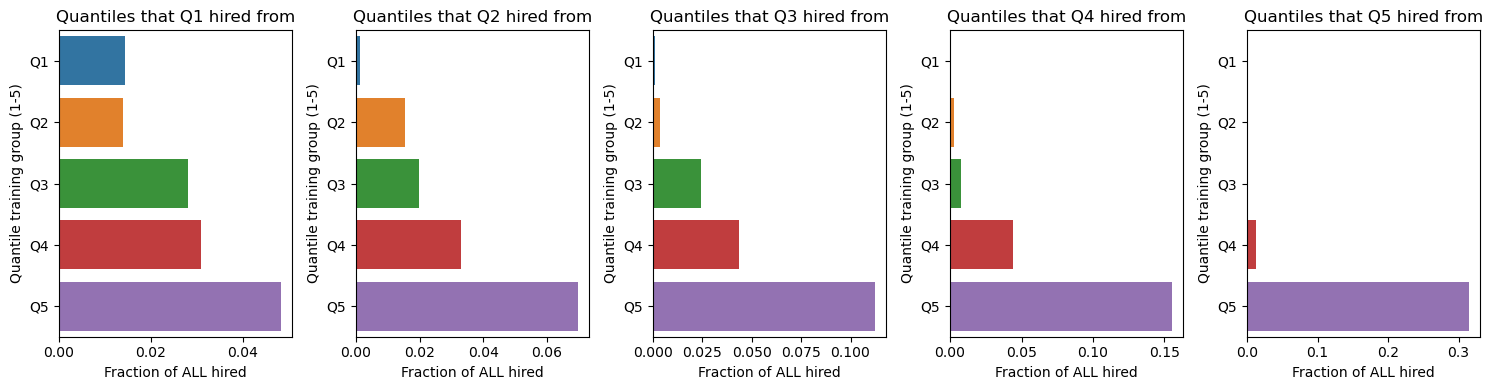

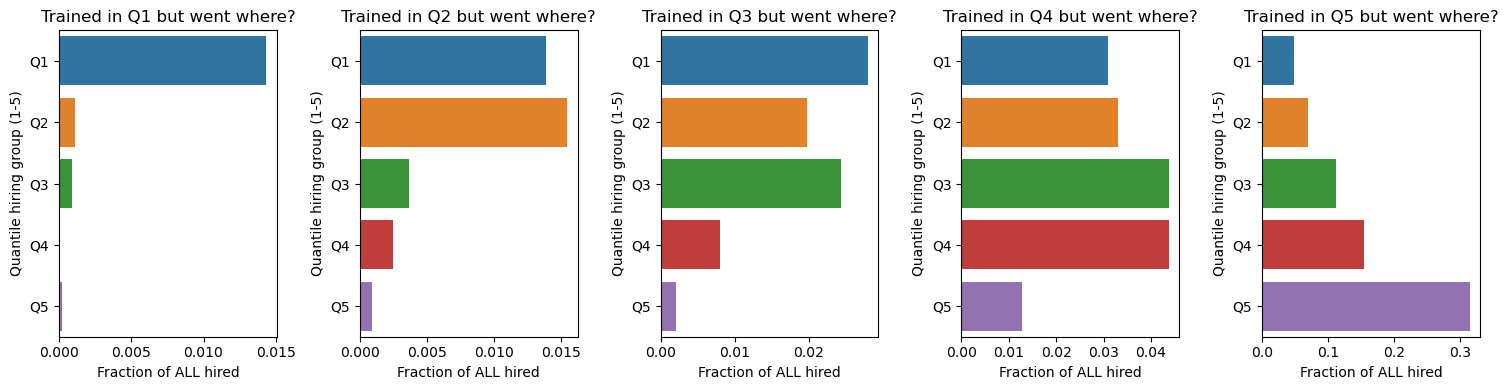

In [124]:
fig, axs = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    qij = nodelist[nodelist.q == f"Q{i+1}"].merge(edgelist, left_on="u", right_on="v").merge(nodelist, left_on="u_y", right_on="u").groupby("q_y")["q_x"].count()#.sort_values(ascending=False)[:N]
    qij_list_name = qij.index.to_list()

    sns.barplot(x=qij/E, y=qij_list_name, ax=axs[i])
    axs[i].set_title(f"Quantiles that Q{i+1} hired from")
    axs[i].set_xlabel("Fraction of ALL hired")
    axs[i].set_ylabel("Quantile training group (1-5)")

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    qij = nodelist[nodelist.q == f"Q{i+1}"].merge(edgelist, left_on="u", right_on="u").merge(nodelist, left_on="v", right_on="u").groupby("q_y")["q_x"].count()
    qij_list_name = qij.index.to_list()

    sns.barplot(x=qij/E, y=qij_list_name, ax=axs[i])
    axs[i].set_title(f"Trained in Q{i+1} but went where?")
    axs[i].set_xlabel("Fraction of ALL hired")
    axs[i].set_ylabel("Quantile hiring group (1-5)")

plt.tight_layout()
plt.show()

**Comment for 2:**

Two plots I made, first fow where the quantiles are hiring from, second where the trained graduates go to. We can on the second plot that the claim  B is true, i.e. that graduates who are hired as professors usually go to universities that are around the same or worse than the universities where they were trained.

Note that for hiring it is a bit different, universities hire usually the upper quantiles, and the better a university is ranked, the less it hires from lower quantiles.

---

In [132]:
edgelist_with_q = edgelist.merge(nodelist[["u", "q"]]).merge(nodelist[["u", "q"]], left_on="v", right_on="u")
up = edgelist_with_q[(edgelist_with_q.q_x == "Q1") & (edgelist_with_q.q_y == "Q5")]
print(up)
down = edgelist_with_q[(edgelist_with_q.q_x == "Q1")]
down.head()

      u_x   v gender q_x  u_y q_y
1280  166  38      M  Q1   38  Q5


,u_x,v,gender,q_x,u_y,q_y
1280,166,38,M,Q1,38,Q5
1943,178,105,M,Q1,105,Q3
2029,167,111,M,Q1,111,Q3
2154,167,167,M,Q1,167,Q1
2155,167,167,M,Q1,167,Q1


In [136]:
X = len(up) / len(down)
print(f"X   = {X:.4f}")
print(f"i.e.  {X*100:.2f}%")

X   = 0.0137
i.e.  1.37%


**Comment:**

The statement is true if we look at a random 1st-quintile ph.d. graduate that got hired somewhere. The chance he got hired by a Q5 is only 1.37 percent. However, the the chance of "getting a job in a 5th-quintile university" if you have applied (not if you were already hired somewhere) is not 1.37, but we do not know that as the data we have is about the professors that got hired, not the applicants! For that case the statement is incorrect.

---

### Task 3 — (25 points)

Let the "source university" of a person be the university at which the person got their Ph.D., and let their "target university" be the university at which they were hired after their Ph.D.


1. For each hiring decision $(u, v)$, let the score gain ($d$) be defined as the difference between the scores of the target university and the source university (target university score minus source university score; see hint for example). Calculate the average difference for men ($\bar{d_{M}}$) and for women ($\bar{d_{F}}$) in the dataset. Determine whether the difference between these two averages ($\bar{d_{M}}$ and $\bar{d_{F}}$) is statistically significant.

2. **/True or false:/** Is the following statement **true** or **false**? Justify your answer. **"The results you obtained in Task 3.1 do not refute the hypothesis that women are disadvantaged in the faculty hiring process."**

3. For each quintile $Q$ from Task 2.1, calculate the following: **(a)** the percentage of women among hiring decisions $(u, v)$ with $u \in Q$ ; and **b)** the average score gain for hiring decisions $(u, v)$ with $u \in Q$.

4. **/Discuss:/** Considering the results obtained in Task 3.3, why is comparing the average score gain for men ($\bar{d_{M}}$) and women ($\bar{d_{F}}$) insufficient for determining the causal effect of gender on score gain?

5. Use `statsmodels` to run a linear regression where hiring decisions (edges of the hiring network) are the data points, gender and source-university score are the predictors, and score gain is the outcome. Report the summary of your model.

6. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"The results you obtained in Task 3.5 suggest that academic hiring decisions are unfair to women."**

---
**Hint** — The university with the best score is Stanford University (score 100), and the university with the 10th best score is the University of Washington (score 95.26). If someone was trained at Stanford and then got a job at the University of Washington, their score gain is $95.26 - 100 = -4.74$.

In [142]:
edgelist_expanded = edgelist.merge(nodelist).merge(nodelist, left_on="v", right_on="u")

dm = edgelist_expanded[edgelist_expanded.gender == "M"]
dm = dm.score_y - dm.score_x

df = edgelist_expanded[edgelist_expanded.gender == "F"]
df = df.score_y - df.score_x

In [160]:
def bootstrap(sample, func, n_boot, seed=None):
    if seed is not None:
        np.random.seed(seed)

    boots = []
    for _ in range(n_boot):
        indices = np.random.randint(0, len(sample), len(sample))
        resample = sample[indices]
        sample_statistic = func(resample)
        boots.append(sample_statistic)

    return np.array(boots)


def percentile_ci(sample, confidence=95, axis=None):
    percentiles = 50 - confidence / 2, 50 + confidence / 2
    return np.nanpercentile(sample, percentiles, axis)


def plot_bootstrap_distribution(sample, boots, ci, confidence, sample_statistic_function):
    fig, ax = plt.subplots(1, 1, dpi=150)
    sample_statistic = sample_statistic_function(sample)
    boots_mean_statistic = boots.mean()
    sns.histplot(boots, color="#3498db", ax=ax)
    plt.axvline(x=sample_statistic, color='#f1c40f', linestyle='-', linewidth=3,
                label=f"sample statistic={sample_statistic:.6f}")
    plt.axvline(x=boots_mean_statistic, color='#c0392b', linestyle='--',
                label=f"bootstrap statistic mean={boots_mean_statistic:.6f}")
    plt.axvline(x=ci[0], color='#2ecc71', linestyle=':', label=f"{confidence}-ci_lower={ci[0]:.6f}")
    plt.axvline(x=ci[1], color='#2ecc71', linestyle=':', label=f"{confidence}-ci_upper={ci[1]:.6f}")
    plt.legend(loc="upper left", fontsize=7)
    plt.show()


def percentile_bootstrap_ci(sample, n_boot, sample_statistic_function, confidence=95, seed=None,
                            plot_boots=False):
    boots = bootstrap(sample, sample_statistic_function, n_boot, seed)
    ci = percentile_ci(boots, confidence)

    if plot_boots:
        plot_bootstrap_distribution(sample, boots, ci, confidence, sample_statistic_function)

    return ci

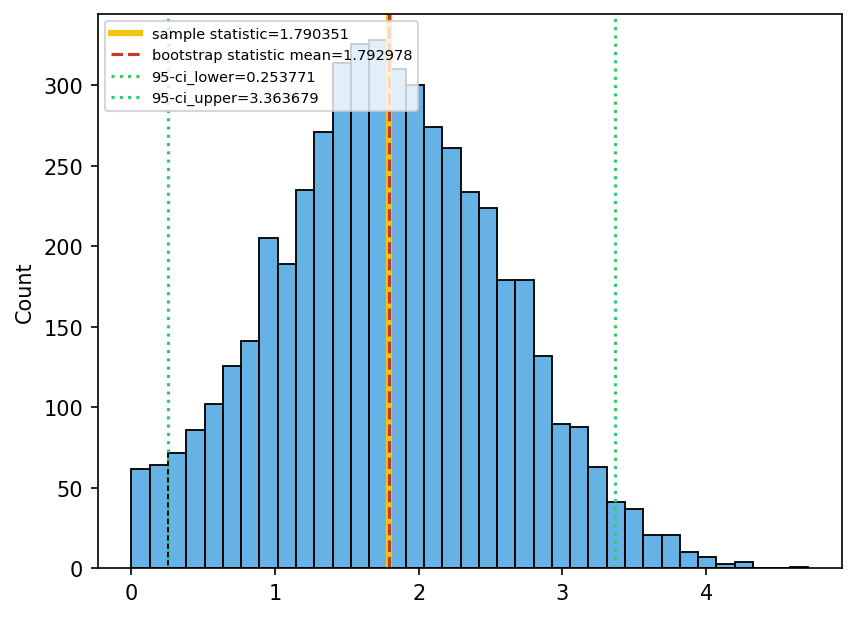

In [161]:
a = dm.sample(len(df)).to_numpy()
b = df.to_numpy()

ci = percentile_bootstrap_ci(
    a - b,
    5000,
    lambda x: np.abs(x.mean()),
    confidence=95,
    plot_boots=True
)

In [164]:
from scipy.stats import ttest_ind
print("Male avg", dm.mean())
print("Female avg", df.mean())
print(f"Difference of averages (male-female): {dm.mean() - df.mean()}")

print("\n\nTTEST")
ttest_ind(dm, df)

Male avg -23.255170534459346
Female avg -25.201988376394855
Difference of averages (male-female): 1.946817841935509


TTEST


Ttest_indResult(statistic=2.509707350544151, pvalue=0.012118868466831183)

**Comment on 1:**

Given alpha=0.05, we have sufficient evidence to claim a significant result for males having a higher average score difference (higher in the sense of less negative). The evidence is based on both the bootstrap intervals (where the 0 is not in the 95-CI) and the independent TTest.

---

**Comment on 2:**

The statement is true for a few reasons, in fact we have significant evidence for the claim to be refuted - that women are disadvantaged.

1. We have significant evidence for the claim being true, not refuted.
2. Even if we could refute that claim and had evidence for it, it is just statistically significant does not need to be true.
3. It is questionable if this this dataset is the one for making real conclusions.
4. Simpson effect might take place if we take into account other information.

---

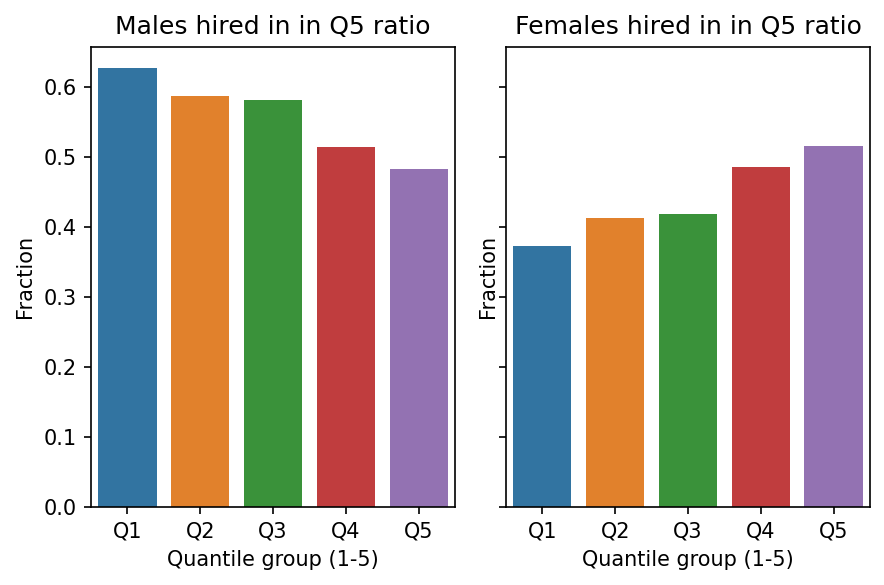

In [216]:
# 3.

q_hires =edgelist_expanded.groupby(["q_y", "gender"]).count()
sum_of_genders = q_hires.groupby("q_y")["v"].sum().to_numpy()
males_ratio = q_hires.unstack()[("v", "M")].to_numpy()/sum_of_genders
female_ratio = q_hires.unstack()[("v", "F")].to_numpy()/sum_of_genders

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,4), dpi=150, sharey=True)

sns.barplot(y=males_ratio, x=[f'Q{i+1}' for i in range(5)], ax=ax1)
ax1.set_title(f"Males hired in in Q{i+1} ratio")
ax1.set_xlabel("Quantile group (1-5)")
ax1.set_ylabel("Fraction")

sns.barplot(y=female_ratio, x=[f'Q{i+1}' for i in range(5)], ax=ax2)
ax2.set_title(f"Females hired in in Q{i+1} ratio")
ax2.set_xlabel("Quantile group (1-5)")
ax2.set_ylabel("Fraction")

plt.tight_layout()
plt.show()

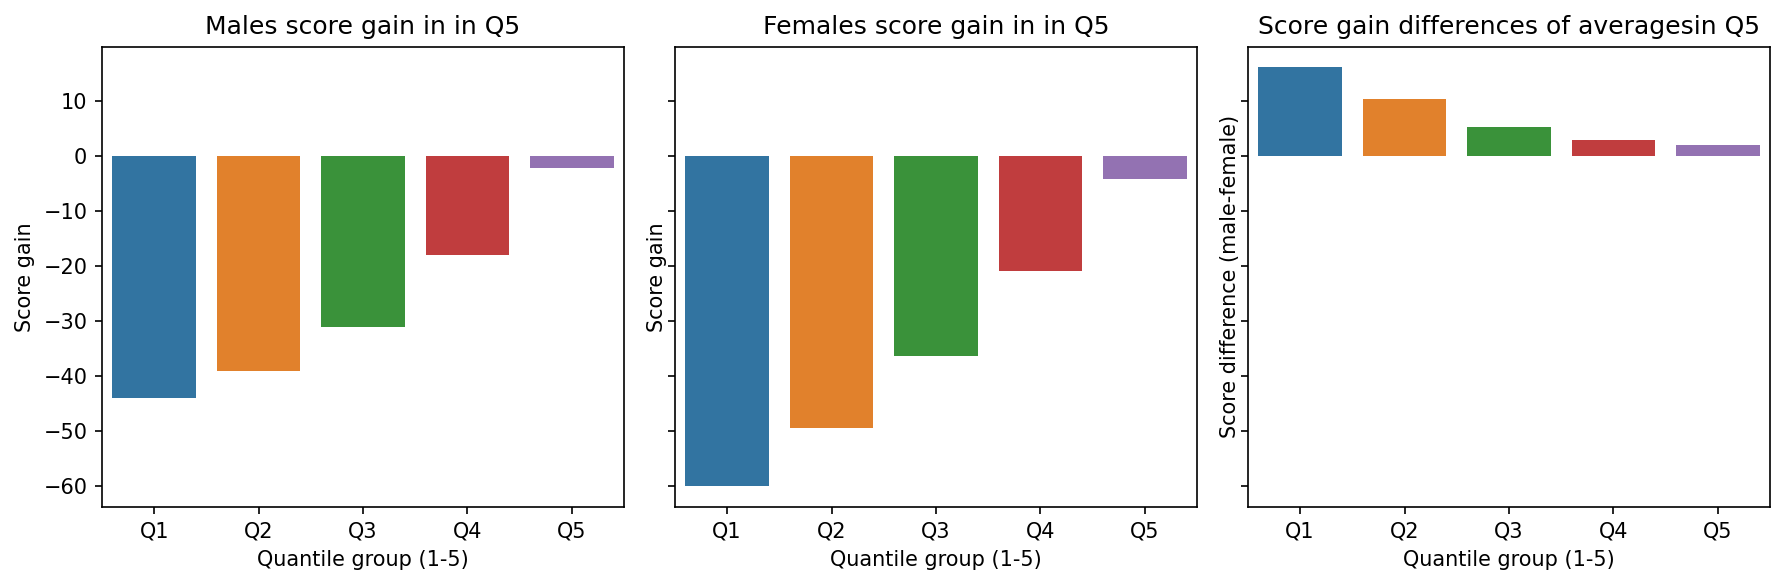

In [238]:
edgelist_expanded["score_gain"] = edgelist_expanded["score_y"] - edgelist_expanded["score_x"]
q_hires = edgelist_expanded.groupby(["q_y", "gender"])["score_gain"].mean()
q_hires = q_hires.unstack()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), dpi=150, sharey=True)

sns.barplot(y=q_hires["M"], x=[f'Q{i+1}' for i in range(5)], ax=ax1)
ax1.set_title(f"Males score gain in in Q{i+1}")
ax1.set_xlabel("Quantile group (1-5)")
ax1.set_ylabel("Score gain")

sns.barplot(y=q_hires["F"], x=[f'Q{i+1}' for i in range(5)], ax=ax2)
ax2.set_title(f"Females score gain in in Q{i+1}")
ax2.set_xlabel("Quantile group (1-5)")
ax2.set_ylabel("Score gain")

sns.barplot(y=q_hires["M"] - q_hires["F"], x=[f'Q{i+1}' for i in range(5)], ax=ax3)
ax3.set_title(f"Score gain differences of averagesin Q{i+1}")
ax3.set_xlabel("Quantile group (1-5)")
ax3.set_ylabel("Score difference (male-female)")

plt.tight_layout()
plt.show()

**Comment:**

Comparing just the averages is ignorant of some subgroups in the data, like these quantile groups. Thus the conclusion could be wrong or even opposite (simsons paradox) if the right covariants are taken into account. In this case the quantile group was important and we see a change in the trend in that the fraction of women hired per quantile just goes up. This means that woman get more hired in better quantiles as the ratio is higher. The fact that it is lower than females does not need to mean that they it is the hiring process that is guilty, maybe less woman applied. But of the woman who got the job, clearly the fraction as opposed to men went up as the quantile got higher.

I got somewhat different results for average score gains per group, not sure why.

---

In [243]:
# 5.

edgelist_expanded["source_university_score"] = edgelist_expanded["score_x"]

model = smf.ols('score_gain ~ C(gender)', data=edgelist_expanded)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             score_gain   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.299
Date:                Tue, 25 Jan 2022   Prob (F-statistic):             0.0121
Time:                        10:37:55   Log-Likelihood:                -20454.
No. Observations:                4388   AIC:                         4.091e+04
Df Residuals:                    4386   BIC:                         4.092e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -25.2020      0.571    -44.

In [245]:
model = smf.ols('score_gain ~ C(gender) + source_university_score', data=edgelist_expanded)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             score_gain   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     112.4
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           2.48e-48
Time:                        10:38:07   Log-Likelihood:                -20347.
No. Observations:                4388   AIC:                         4.070e+04
Df Residuals:                    4385   BIC:                         4.072e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Comment on 6:**

False --> The results obtained actually suggest that academic hiring decisions are FAIR to women, as being a man had a negative coefficient. Note that this effect could not have been observed without the inclusion of the "source_university_score". In fact, including other variables (measured or unmeasuared=con-founders) could yield a different conclusion again!

---

## Part 2 — Tennis interviews

For the second part of the exam, you will work with text data extracted from questions asked during post-match tennis interviews and from
TV commentary done during the tennis match.


Examples of interview questions:

> That last set seemed like a faultless performance. Is that the way you saw it?

> How disappointing is that loss for you?

> As a spectator, would you rather watch a guy with big aces or a match with lots of rallies?

Example of commentary text:

>  Serena is desperate to shake herself into action. She lets out an almighty shriek when she goes 30-15 up, but Azarenka responds with a brilliant forehand. The level of Williams' scream goes up and up during the next point, and she lets out another roar when she belts a forehand cross court win the point. She wraps the game up next time round, and she looked something like back to her best there!


## Files (in the `data` folder)

- `questions.tsv.gz` a tab-separated compressed file containing interview questions
and some metadata. We refer to this dataset as the "questions dataset."
Each row contains a question made to a specific player after a match.
The file has the following columns:
    - `questions` — the text of the question asked; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the player;
    - `ranking` — the ranking of the player at the time;
    - `similarity` — this column will be explained later in the exam.

- `commentary.tsv.gz` a tab-separated compressed file containing TV commentary done during
the tennis match. We refer to this dataset as the "commentary dataset." Each line contains
a piece of commentary done in a tennis match.
The file has the following columns:
    - `commentary` — the text of the commentary; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the players in the match;

- `TFIDF.npz`, a file containing 2D numpy arrays saved in the `.npz` format that
will be used in Task 4.

Both datasets are **balanced regarding gender,** i.e., they have the same number of rows about men as about women.


Commentary text, as well as interview questions, have been preprocessed to make your life easier, as follows:

- We replaced all words starting with upper-case letters with the special string `'--ENT--'`. This was done to remove personal names (e.g., Alice, Bob), which could help predict whether the text is associated with a male or a female tennis player.
- We removed the first word in each sentence. This was done because, for the first word of each sentence, it is difficult to know whether it is a personal name or simply a regular word.
- We replaced all gendered pronouns in the text (he/him/his and she/her/hers) with the special string `'--PRON--'`. This, too, was done because these words would make it easy to predict whether the text is associated with a male or a female tennis player.
- We removed punctuation and stop words (to reduce the dimensionality of the data).

The above example commentary text thus appears as follows in the data provided to you:

> desperate shake action lets almighty shriek --PRON-- goes 30 15 --ENT-- responds brilliant forehand level --ENT-- scream goes point --PRON-- lets roar --PRON-- belts forehand cross court win point wraps game time round --PRON-- looked like --PRON-- best

We also provide some code for loading and displaying the dataset:

In [265]:
#  Part 2 ! PROVIDED CODE !

questions = pd.read_csv("./data/part-2/questions.tsv.gz", sep="\t", compression="infer")
commentary = pd.read_csv("./data/part-2/commentary.tsv.gz", sep="\t", compression="infer")

print(len(questions))
print(len(commentary))

3000
3000


In [266]:
questions.head()

,questions,ranking,similarity,gender
0,successful --ENT-- today year,366,0.431568,F
1,players player admire growing,352,0.247449,F
2,shot clock thing countdown,441,0.702559,F
3,birthplace --ENT-- place lot --ENT-- --ENT-- b...,760,0.270464,F
4,--ENT-- match today,99,0.322474,F


In [267]:
commentary.head()

,commentary,gender
0,restarts contest foot --ENT-- reaches 30 15 he...,M
1,start --ENT-- --ENT-- moves 15 0 ahead --ENT--...,M
2,continues struggle --ENT-- serve proves diffic...,M
3,hold 15 begin second set NoDjo gasp break --PR...,M
4,hold --ENT-- --PRON-- wo fight easily competit...,M


### Task 4  (20 points)

Your goal now is to investigate whether there is gender bias in the questions being asked to female vs. male players, i.e., whether men vs. women are asked different questions on average. You start your analysis with a classification framing.


To make your life easier, we already provided a TF-IDF matrix for each dataset (`commentary.tsv.gz` and `questions.tsv.gz`) and with code to load these matrices (which are numpy arrays).

- Each row in each matrix $M$ corresponds to a row in the corresponding dataframe, i.e., each row corresponds to a different question or a different piece of TV commentary.
- Each column in each matrix corresponds to a different word from the vocabulary.
- Each position $(i,j)$ in the matrix contains the TF-IDF score for word $j$ from the vocabulary in question or commentary $i$. That is, each term $M[i,j]$ corresponds to the term frequency (TF) of word $j$ in text $i$, multiplied by the inverse document frequency (IDF) of word $j$:


$$M[i,j] = \text{TF}(i,j) * \text{IDF}(j)$$


1. **/Multiple Choice:/** Which of the following is the correct way to calculate the term frequency and the inverse document frequency? Justify your answer, explaining what each of the two components should capture.
    - Option A:

    $$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option B:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option C:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$

    - Option D:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$



2. Leveraging the matrices described above, train two logistic regression classifiers (one for interview questions, the other for TV commentary) that use the TF-IDF vectors as features to predict the gender of the athletes. You should split each dataset into training and test sets using sklearn (see [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) using parameters `test_size=0.4` and `random_state=42`. You should use sklearn's logistic regression model (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)) using parameters `C=10` (which controls regularization) and `max_iter=2000`. For each dataset, train the model on the training set (with 60% of the data) and report the accuracy on the test set (with 40% of the data).

3. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"Based on the outcome of Task 4.2, the text from tennis commentary text is more gender-biased than post-match questions."**

4. The parameter `C` above controls a regularization penalty. The lower `C`, the stronger the regularization penalty (caveat: sklearn’s convention is the reverse of the convention you saw in class, where a *higher* $\lambda$ parameter meant a stronger regularization penalty ). For the questions dataset, re-run the classification task using the same setup as in Task 4.2, but now with `C=2000`. Report the accuracy.

5. **/Discuss:/** Explain why increasing `C` changed the results.


In [268]:
# 4.2 ! PROVIDED CODE !
tmp = np.load("./data/part-2/TFIDF.npz")
TFIDF_commentary = tmp['commentary']
TFIDF_questions = tmp['questions']

TFIDF_questions[:10]

array([[0.60373585, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19567434],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Comment on 1:**

Answer: **D**

TF must have the count of the i-th word in the j-th document, this measures how representative the i-th word is of the j-th document. So options B and D are left

IDF must have number of documents in the numerator if the **log is with a + sign in front**, it is an inverse document  frequency which tells about the inverse of the number of documents in which the term appears. It is important to include it so that the words that apppear in all documents do not matter so much, as they should not (for example stop words would have low IDF, but words peculiar to a few documents would not). So D is the answer.

---

In [269]:
# 2.

from sklearn.model_selection import train_test_split

X_q = TFIDF_questions
y_q = (questions.gender == "M").astype(int)

X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.4, random_state=42)

print('Number of train samples:', X_q_train.shape[0])
print('Number of train features:', X_q_train.shape[1])
print('Number of train labels:', len(y_q_train))
print()
print('Number of test samples:', X_q_test.shape[0])
print('Number of test features:', X_q_test.shape[1])
print('Number of test labels:', len(y_q_test))

Number of train samples: 1800
Number of train features: 5497
Number of train labels: 1800

Number of test samples: 1200
Number of test features: 5497
Number of test labels: 1200


In [274]:
X_c = TFIDF_commentary
y_c = (commentary.gender == "M").astype(int)

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=0.4, random_state=42)

print('Number of train samples:', X_c_train.shape[0])
print('Number of train features:', X_c_train.shape[1])
print('Number of train labels:', len(y_c_train))
print()
print('Number of test samples:', X_c_test.shape[0])
print('Number of test features:', X_c_test.shape[1])
print('Number of test labels:', len(y_c_test))

Number of train samples: 1800
Number of train features: 5497
Number of train labels: 1800

Number of test samples: 1200
Number of test features: 5497
Number of test labels: 1200


In [280]:

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


clf = LogisticRegression(C=10, max_iter=2000, random_state=42)
clf.fit(X_q_train, y_q_train)
y_q_pred_train = clf.predict(X_q_train)
y_q_pred_test = clf.predict(X_q_test)

print("TRAIN")
print(classification_report(y_q_train, y_q_pred_train, digits=3))
print("\n\nTEST")
print(classification_report(y_q_test, y_q_pred_test, digits=3))

TRAIN
              precision    recall  f1-score   support

           0      0.855     0.678     0.756       856
           1      0.754     0.896     0.819       944

    accuracy                          0.792      1800
   macro avg      0.805     0.787     0.788      1800
weighted avg      0.802     0.792     0.789      1800



TEST
              precision    recall  f1-score   support

           0      0.760     0.626     0.687       607
           1      0.676     0.798     0.732       593

    accuracy                          0.711      1200
   macro avg      0.718     0.712     0.709      1200
weighted avg      0.718     0.711     0.709      1200



In [281]:
clf = LogisticRegression(C=10, max_iter=2000, random_state=42)
clf.fit(X_c_train, y_c_train)
y_c_pred_train = clf.predict(X_c_train)
y_c_pred_test = clf.predict(X_c_test)

print("TRAIN")
print(classification_report(y_c_train, y_c_pred_train, digits=3))
print("\n\nTEST")
print(classification_report(y_c_test, y_c_pred_test, digits=3))

TRAIN
              precision    recall  f1-score   support

           0      0.590     0.685     0.634       918
           1      0.606     0.505     0.551       882

    accuracy                          0.597      1800
   macro avg      0.598     0.595     0.592      1800
weighted avg      0.598     0.597     0.593      1800



TEST
              precision    recall  f1-score   support

           0      0.499     0.595     0.542       582
           1      0.534     0.437     0.480       618

    accuracy                          0.513      1200
   macro avg      0.516     0.516     0.511      1200
weighted avg      0.517     0.513     0.510      1200



**Comment on 2:**

FALSE

Being harder to learn does not mean that there is any gender-bias, but that the task from the commentary is more harder to grasp for the model and use to learn to predict the gender (which is why the accuracy is lower by about 20% on BOTH train and test)! Also it might be the wrong hyperparameters, not the hardness of the task...

---



In [285]:
clf = LogisticRegression(C=2000, max_iter=2000, random_state=42)
clf.fit(X_q_train, y_q_train)
y_q_pred_train = clf.predict(X_q_train)
y_q_pred_test = clf.predict(X_q_test)

print("TRAIN")
print(classification_report(y_q_train, y_q_pred_train, digits=3))
print("\n\nTEST")
print(classification_report(y_q_test, y_q_pred_test, digits=3))

TRAIN
              precision    recall  f1-score   support

           0      0.974     0.947     0.960       856
           1      0.953     0.977     0.965       944

    accuracy                          0.963      1800
   macro avg      0.964     0.962     0.963      1800
weighted avg      0.963     0.963     0.963      1800



TEST
              precision    recall  f1-score   support

           0      0.711     0.649     0.679       607
           1      0.670     0.730     0.699       593

    accuracy                          0.689      1200
   macro avg      0.691     0.690     0.689      1200
weighted avg      0.691     0.689     0.689      1200



In [286]:
clf = LogisticRegression(C=2000, max_iter=2000, random_state=42)
clf.fit(X_c_train, y_c_train)
y_c_pred_train = clf.predict(X_c_train)
y_c_pred_test = clf.predict(X_c_test)

print("TRAIN")
print(classification_report(y_c_train, y_c_pred_train, digits=3))
print("\n\nTEST")
print(classification_report(y_c_test, y_c_pred_test, digits=3))

TRAIN
              precision    recall  f1-score   support

           0      0.781     0.775     0.778       918
           1      0.767     0.774     0.771       882

    accuracy                          0.774      1800
   macro avg      0.774     0.774     0.774      1800
weighted avg      0.775     0.774     0.774      1800



TEST
              precision    recall  f1-score   support

           0      0.545     0.564     0.554       582
           1      0.575     0.557     0.566       618

    accuracy                          0.560      1200
   macro avg      0.560     0.560     0.560      1200
weighted avg      0.561     0.560     0.560      1200



**Comment:**

Changing the hyperparametrs tends to change the results in general. In this case we saw that lowering the amount of regularization helped both models to train better (i mean higher train accuracy), but the test accuracies have a different pattern for the two datasets.

For the questions it seems to have not helped but worsen the performance, this might be the case if the model overfit.

For commentary, it helped a little, which might mean that in the first setup the regularization amount was to high!

---

### Task 5 — (20 pts)

You will now further inspect whether there is gender bias in the interview questions using an observational study framing. For this task, you will use the column `similarity` provided in the questions dataframe. This column captures how similar each question is to tennis-related text, i.e., a higher score indicates that the question is more about the topic of tennis. In contrast, a lower score means that the question may be personal or about other subjects.

1. Using `statsmodels`, run a linear regression with `similarity` as the predictor and `gender` as the outcome. Report the summary of your model.

2. **/True or false:/** According to the previous analysis, determine if the following statement is **true** or **false** and justify your answer. **"Men are asked questions unrelated to tennis more often than women."**

3. The ranking of players is a potential confounder here. We do not know whether the male and female players in the dataset have similar rankings. In that context, compute the average ranking for men and women. Determine if the difference is statistically significant. Additionally, create a scatter plot showing the relationship between ranking (on the y-axis) and similarity (in the x-axis) and compute Spearman's rank-correlation coefficient between `ranking` and `similarity`.

4. **/True or false:/** Assume that no variable other than `gender` and `ranking` can have any influence on the `similarity` of each question. Based on the analysis of the previous question, is the following statement **true** or **false**? Justify your answer. **"Ranking is not a worrisome confounder for the regression of Task 5.1."**

In [301]:
questions["gender_c"] = (questions.gender == "M").astype(int)

model = smf.ols('gender_c ~ similarity', data=questions)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               gender_c   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     841.1
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          3.16e-163
Time:                        11:17:47   Log-Likelihood:                -1805.5
No. Observations:                3000   AIC:                             3615.
Df Residuals:                    2998   BIC:                             3627.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0713      0.017      4.142      0.0

**Comment:**

FALSE

According to the similarity coefficient and having in mind that a positive gender means MALE in my setup, and ignoring con-founders, we would rather say that men are asked question that are similar aka related to tennis, because the coefficient with similarity is positive (so larger similarity, more of a men).

---

In [306]:
model = smf.ols('gender_c ~ similarity + ranking', data=questions)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               gender_c   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     420.7
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          9.06e-162
Time:                        11:23:46   Log-Likelihood:                -1805.3
No. Observations:                3000   AIC:                             3617.
Df Residuals:                    2997   BIC:                             3635.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0810      0.022      3.648      0.0

In [307]:
dm = questions[questions.gender == "M"].ranking
df = questions[questions.gender == "F"].ranking

print("Male avg ranking:", dm.mean())
print("Female avg ranking:", df.mean())
print(f"Difference of averages (male-female): {dm.mean() - df.mean()}")

print("\n\nTTEST")
ttest_ind(dm, df)


Male avg ranking: 495.20234222511385
Female avg ranking: 503.6179084073821
Difference of averages (male-female): -8.415566182268265


TTEST


Ttest_indResult(statistic=-0.7959498763790183, pvalue=0.42612418722112966)

In [308]:
stats.spearmanr(questions.ranking, questions.similarity)

SpearmanrResult(correlation=-0.00793480965681015, pvalue=0.663973935968952)

**Comment:**

TRUE

Ranking is not a worrisome confounder as we saw that the difference of the genders are non significant with respect to it (p-value=0.426). I confirm this by running another OLS with ranking included.

---